# LeNet5 Implementation from Scratch

In [1]:
#import package
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time

In [2]:
from utils.LayerObjects import *
from utils.utils_func import *

In [3]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))

In [4]:
imgs=[]
for i in images:
    img=cv2.resize(i,(64,64))
    imgs.append(img)

In [5]:
imagesarr=np.asarray(imgs)
imagescatarr=np.asarray(imagescat)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(imagescatarr)
encoded_imagescatarr = encoder.transform(imagescatarr)
imagescatarr = np_utils.to_categorical(encoded_imagescatarr)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imagesarr,imagescatarr, test_size=0.1, random_state=0)

split_indext = np.concatenate((np.ones(round(len(y_trainvalid)*0.8)), np.zeros(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)
split_indexv = np.concatenate((np.zeros(round(len(y_trainvalid)*0.8)), np.ones(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)

(train_image, train_label) = (X_trainvalid[split_indext], y_trainvalid[split_indext])
(valid_image, valid_label) = (X_trainvalid[split_indexv], y_trainvalid[split_indexv])
(test_image, test_label) = (X_test, y_test)
n_m, n_m_valid, n_m_test = len(train_label),len(valid_label), len(test_label)
print("The shape of training image:", train_image.shape)
print("The shape of validing image:", valid_image.shape)
print("The shape of testing image: ", test_image.shape)
print("Length of the training set: ", n_m)
print("Length of the validing set:", n_m_valid)
print("Length of the testing set: ", n_m_test)
print("Shape of a single image: ", train_image[0].shape)

The shape of training image: (46242, 64, 64, 3)
The shape of validing image: (11560, 64, 64, 3)
The shape of testing image:  (6423, 64, 64, 3)
Length of the training set:  46242
Length of the validing set: 11560
Length of the testing set:  6423
Shape of a single image:  (64, 64, 3)


In [15]:
def normalize(image):
    image = image.astype(np.float)
    for i in range(image.shape[0]):
        for c in range(3):
            channel = image[i,:, :, c]
            channel -= channel.min()
            channel = channel / channel.max()
            image[i,:, :, c] = channel
    return image
train_image = normalize(train_image)
valid_image = normalize(valid_image)
test_image  = normalize(test_image)

In [16]:
# Designate combination of kernels and feature maps of S2.
C3_mapping = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,0],[5,0,1],\
              [0,1,2,3],[1,2,3,4],[2,3,4,5],[3,4,5,0],[4,5,0,1],[5,0,1,2],\
              [0,1,3,4],[1,2,4,5],[0,2,3,5],\
              [0,1,2,3,4,5]]

In [17]:
# LeNet5 object (also stored in utils/LayerObjects.py)
class LeNet5(object):
    def __init__(self):
        kernel_shape = {"C1": (3,3,3,6),
                        "C3": (3,3,6,16),
                        "C3_2": (3,3,16,32),
                        "C5": (3,3,32,120), 
                        "F6": (120,84),
                        "OUTPUT": (84,50)}
        
        hparameters_convlayer = {"stride": 1, "pad": 0}
        hparameters_pooling   = {"stride": 2, "f": 2}        
        
        self.C1 = ConvLayer(kernel_shape["C1"], hparameters_convlayer,init_mode='Fan-in')
        self.a1 = Activation("tanh")
        self.S2 = PoolingLayer(hparameters_pooling, "average")
        
        self.C3 = ConvLayer_maps(kernel_shape["C3"], hparameters_convlayer, C3_mapping,init_mode='Fan-in')
        self.a2 = Activation("tanh")
        self.S4 = PoolingLayer(hparameters_pooling, "average")
        
        self.C3_2 = ConvLayer(kernel_shape["C3_2"], hparameters_convlayer,init_mode='Fan-in')
        self.a2_2 = Activation("tanh")
        self.S4_2 = PoolingLayer(hparameters_pooling, "average")
        
        self.C5 = ConvLayer(kernel_shape["C5"], hparameters_convlayer,init_mode='Fan-in')
        self.a3 = Activation("tanh")

        self.F6 = FCLayer(kernel_shape["F6"])
        self.OUTPUT = FCLayer(kernel_shape["OUTPUT"])
        self.softmax = Softmax()
        self.ce = CrossEntropy()
        
    def Forward_Propagation(self, input_image, input_label, mode): 
        self.label = input_label
        self.C1_FP = self.C1.foward_prop(input_image)
        self.a1_FP = self.a1.foward_prop(self.C1_FP)
        self.S2_FP = self.S2.foward_prop(self.a1_FP)
      
        self.C3_FP = self.C3.foward_prop(self.S2_FP)
        self.a2_FP = self.a2.foward_prop(self.C3_FP)
        self.S4_FP = self.S4.foward_prop(self.a2_FP)
        
        self.C3_2_FP = self.C3_2.foward_prop(self.S4_FP)
        self.a2_2_FP = self.a2_2.foward_prop(self.C3_2_FP)
        self.S4_2_FP = self.S4_2.foward_prop(self.a2_2_FP)

        self.C5_FP = self.C5.foward_prop(self.S4_2_FP)
        self.a3_FP = self.a3.foward_prop(self.C5_FP)
        self.flatten = self.a3_FP[:,0,0,:]
        
        self.F6_FP = self.F6.foward_prop(self.flatten)

        self.OUTPUT_FP = self.OUTPUT.foward_prop(self.F6_FP)
        self.softmax_FP = self.softmax.forward(self.OUTPUT_FP)

        print(self.softmax_FP[0],input_label[0])
        if mode == 'train':
            return self.ce.forward(self.softmax_FP,input_label)
        if mode == 'test':
            class_pred = np.argmax(self.softmax_FP, axis=1)
            class_act = np.argmax(input_label, axis=1)
            error01 = np.sum((class_pred != class_act).astype(int))
            return error01, class_pred
        
    def Back_Propagation(self, momentum, weight_decay):
        dy_pred = self.softmax_FP - self.label
        OUTPUT_BP = self.OUTPUT.back_prop(dy_pred, momentum, weight_decay)
        F6_BP = self.F6.back_prop(OUTPUT_BP, momentum, weight_decay)
        
        reverse_flatten = F6_BP[:,np.newaxis,np.newaxis,:]
        reverse_flatten = self.a3.back_prop(reverse_flatten) 
        C5_BP = self.C5.back_prop(reverse_flatten, momentum, weight_decay)
        
        S4_2_BP = self.S4_2.back_prop(C5_BP)
        S4_2_BP = self.a2_2.back_prop(S4_2_BP)
        C3_2_BP = self.C3_2.back_prop(S4_2_BP, momentum, weight_decay) 
        
        S4_BP = self.S4.back_prop(C3_2_BP)
        S4_BP = self.a2.back_prop(S4_BP)
        C3_BP = self.C3.back_prop(S4_BP, momentum, weight_decay) 
        
        S2_BP = self.S2.back_prop(C3_BP)
        S2_BP = self.a1.back_prop(S2_BP)  
        print('S2_BP',np.mean(S2_BP[0,:,:,0]),np.std(S2_BP[0,:,:,0]))
        C1_BP = self.C1.back_prop(S2_BP, momentum, weight_decay)
        
        
class Softmax():
    def forward(self,x):
        # Subtract the maximum value of x to avoid overflow errors
        self.max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - self.max_x)
        #exp_x = np.exp(x)
        self.old_y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.old_y

    def backward(self,grad):
        return self.old_y * (grad - np.sum(grad * self.old_y, axis=1, keepdims=True))

class CrossEntropy():
    def forward(self,x,y):
        self.old_x = x.clip(min=1e-8,max=None)
        self.old_y = y
        return sum((np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1))

    def backward(self):
        return np.where(self.old_y==1,-1/self.old_x, 0)

In [18]:
ConvNet = LeNet5()
ConvNet.C1.lr, ConvNet.C3.lr,ConvNet.C3_2.lr, ConvNet.C5.lr, ConvNet.F6.lr, ConvNet.OUTPUT.lr = np.ones(6)*0.000025

In [19]:
epoches = 20
momentum = 0.9
weight_decay = 0
batch_size = 256

In [20]:
#Training loops
st = time.time()
cost_last, count = np.Inf, 0
err_rate_list = []
for epoch in range(0,epoches):
    print("---------- epoch", epoch+1, "begin ----------")
    
    
    #loop over each batch
    ste = time.time()
    cost = 0
    mini_batches = random_mini_batches(train_image, train_label, batch_size)
    for i in range(len(mini_batches)):
        batch_image, batch_label = mini_batches[i]
        
        loss = ConvNet.Forward_Propagation(batch_image, batch_label, 'train')     
        cost += loss
        
        ConvNet.Back_Propagation(momentum, weight_decay) 

        # print progress
        if i%(int(len(mini_batches)/100))==0:
            sys.stdout.write("\033[F")   #CURSOR_UP_ONE
            sys.stdout.write("\033[K")   #ERASE_LINE
            print ("progress:", int(100*(i+1)/len(mini_batches)), "%, ", "cost =", cost, end='\r')

    sys.stdout.write("\033[F")   #CURSOR_UP_ONE
    sys.stdout.write("\033[K")   #ERASE_LINE
    
    print ("Done, cost of epoch", epoch+1, ":", cost,"                                             ")
    
    error01_train, _ = ConvNet.Forward_Propagation(train_image, train_label, 'test')  
    error01_test, _  = ConvNet.Forward_Propagation(valid_image,  valid_label,  'test')     
    err_rate_list.append([error01_train, error01_test])
    print(" error of training set:",  error01_train, "/", len(train_label))
    print(" error of validing set: ",  error01_test,  "/", len(valid_label))
    print("Time used: ",time.time() - ste, "sec")
    print("---------- epoch", epoch+1, "end ------------")

err_rate_list = np.array(err_rate_list).T
print("Total time used: ", time.time() - st, "sec")

---------- epoch 1 begin ----------
[0.02002992 0.01981801 0.02001661 0.0198416  0.0201413  0.01988033
 0.02028652 0.01984078 0.02002234 0.0199562  0.02003501 0.0198513
 0.0199035  0.02014168 0.01976712 0.01993198 0.02023395 0.02024863
 0.02001781 0.02024803 0.02028827 0.01992002 0.01967891 0.0205222
 0.01998031 0.02015199 0.02057654 0.01963226 0.02009569 0.02001367
 0.01983616 0.01996857 0.01992431 0.02041329 0.02007391 0.01991399
 0.01982813 0.02038921 0.019612   0.01999145 0.0194439  0.02017406
 0.02021571 0.01991119 0.0197557  0.01983114 0.02015285 0.01986353
 0.01996559 0.01966285] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S2_BP 3.3587650651960565e-06 3.3787125612754374e-06
[0.02001081 0.01983759 0.02001528 0.01984491 0.02014916 0.01988133
 0.02028895 0.01983747 0.02000429 0.01995024 0.02005356 0.01984445
 0.01988635 0.0201314  0.01978887 0.01993188 0.02024689 0.02025761

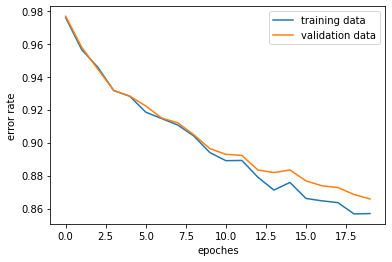

In [37]:
# This shows the error rate of training and testing data after each epoch
err_rate_list=np.array(err_rate_list)
x = np.arange(epoches)[0:err_rate_list.shape[1]]
plt.xlabel('epoches')
plt.ylabel('error rate')
plt.plot(x, err_rate_list[0,:]/len(train_label))
plt.plot(x, err_rate_list[1,:]/len(valid_label))
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [31]:
error01, class_pred = ConvNet.Forward_Propagation(valid_image, valid_label, 'test')
print("accuracy:", 1-error01/len(class_pred))

[0.03177576 0.01296878 0.01104125 0.02510073 0.05223858 0.01696352
 0.17438987 0.06425673 0.07455774 0.03577994 0.02841064 0.03053248
 0.01351749 0.01516128 0.00327025 0.02639363 0.00576919 0.02808675
 0.01465905 0.00360707 0.0033031  0.01593437 0.00799248 0.00582092
 0.01615807 0.02198209 0.02345541 0.01880587 0.03126881 0.02300431
 0.01675421 0.00773846 0.00659621 0.00247422 0.00498676 0.00519758
 0.01504195 0.00200328 0.01046066 0.00326744 0.00189406 0.00581361
 0.00623155 0.00882733 0.00146681 0.01575338 0.01546311 0.01900323
 0.01141891 0.00340108] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
accuracy: 0.13416955017301035


In [32]:
prediction_ = np.argmax(ConvNet.softmax_FP, axis = 1)
actual_ = np.argmax(valid_label, axis = 1)
np.mean(prediction_==actual_)

0.13416955017301038

In [33]:
maxfive=np.argsort(ConvNet.softmax_FP, axis=1)[:,-5:]
actual= np.argmax(valid_label, axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.4024221453287197

In [34]:
error01, class_pred = ConvNet.Forward_Propagation(test_image, test_label, 'test')
print("accuracy:", 1-error01/len(class_pred))

[0.00310085 0.00801434 0.00357966 0.01346341 0.02069998 0.00414422
 0.06542325 0.03414526 0.0200034  0.01471496 0.0093668  0.01238294
 0.00670484 0.00398797 0.00226352 0.02158387 0.01787628 0.02197584
 0.02360051 0.0087651  0.0118287  0.04133933 0.03332363 0.00384589
 0.00838325 0.0132041  0.0274799  0.00675005 0.0100616  0.00767569
 0.00840471 0.0097813  0.0166304  0.00106378 0.01165205 0.02201205
 0.01541376 0.01763912 0.03383464 0.00087826 0.00246643 0.00135848
 0.0239439  0.02735762 0.00741728 0.12861729 0.03815065 0.05861687
 0.07351037 0.02156191] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0.]
accuracy: 0.12190565156468935


In [35]:
prediction_ = np.argmax(ConvNet.softmax_FP, axis = 1)
actual_ = np.argmax(test_label, axis = 1)
np.mean(prediction_==actual_)

0.1219056515646894

In [36]:
maxfive=np.argsort(ConvNet.softmax_FP, axis=1)[:,-5:]
actual= np.argmax(test_label, axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.39934609995329284